In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nb

from sklearn.model_selection import train_test_split

import math
from functools import partial

import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
import datetime
import copy

import Models as published_models

In [2]:
BASE_DIR="./brains/"

data_df=pd.read_excel('Classification_clean.xlsx')

data_df["Class"]=data_df["Diagnosis"]>0
#data_df["Class"]=data_df["FEP_binary"]>0

data_df.Class = data_df.Class.astype('int')


data_df.head()

,ID_CF,FirstEpisodes_FEP__HealthyControl_HC_,FEP_binary,Diagnosis,Gender,Age,Site 1,Site 2,Site 3,Site 4,Site 5,Site 6,Site 7,Euler,Test,Class
0,CF_001,FEP,1,3,0,23.857632,0,0,0,0,0,0,0,-21,0,1
1,CF_002,FEP,1,3,0,28.952772,0,0,0,0,0,0,0,-33,1,1
2,CF_003,FEP,1,1,0,20.199863,0,0,0,0,0,0,0,-55,0,1
3,CF_004,FEP,1,1,0,28.517454,0,0,0,0,0,0,0,-26,1,1
4,CF_005,FEP,1,2,1,39.101985,0,0,0,0,0,0,0,-24,0,1


In [3]:
class Milano_MRI_Dataset(Dataset):
    def __init__(self,df:pd.DataFrame,imfolder:str,train:bool = True, transforms=None):
        self.df=df
        self.imfolder=imfolder
        self.train=train
        #self.transforms=transforms
        
    def __getitem__(self,index):
        filename='w'+self.df.iloc[index]['ID_CF']+'_MRI_sMRI_'+self.df.iloc[index]['ID_CF']+'_brain.nii.gz';
        
        im_path=os.path.join(self.imfolder,filename)
        
        nimg = nb.load(im_path)
        x = np.array(nimg.dataobj)
        #x=nimg.get_fdata()
        x = transforms.ToTensor()(x)
        x=x.unsqueeze(0).type(torch.FloatTensor);
        m=torch.mean(x)
        s=torch.std(x)
        x=(x-m)/s
        
        #x=torch.nn.functional.interpolate(x, size=(32,32,10), mode='trilinear)
        
        #if(self.transforms):
        #    x=self.transforms(image=x)['image']
        
        if(self.train):
            y=self.df.iloc[index]['Class']
            return x,y
        else:
            return x
        
    def __len__(self):
        return len(self.df)




In [4]:
train = data_df[data_df['Test']==0]
valid = data_df[data_df['Test']==1]

# reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

train_targets = train.Class.values

# targets for validation
valid_targets = valid.Class.values

train_dataset=Milano_MRI_Dataset(
    df=train,
    imfolder=BASE_DIR,
    train=True,
    transforms=None
)

valid_dataset=Milano_MRI_Dataset(
    df=valid,
    imfolder=BASE_DIR,
    train=True,
    transforms=None
)

train_loader = DataLoader(
    train_dataset,
    batch_size=10,
    #num_workers=4,
    shuffle=True,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=10,
    #num_workers=4,
    shuffle=False,
)

# A simple 3D CNN 

In [5]:
# Tufail_CNN - Brain Inf. (2021)
# Oh_CNN - Front Psychiatry 2020 Feb 3;11:16
# Zunair_CNN - Lecture Notes in Computer Science book series (LNIP,volume 12329), pp 156–168 (2020)
# Li_CNN - Computerized Medical Imaging and Graphics 89 (2021) 101882
# AlexNet_3D - Front. Neurol., 08 April 2020
# VoxCNN - ISBI 2017, pp 835–838
# VoxResNet21 - ISBI 2017, pp 835–838

In [6]:
model_list = [published_models.Tufail_CNN(2),published_models.Oh_CNN(2),published_models.Zunair_CNN(2),published_models.Li_CNN(2),published_models.AlexNet_3D(2),published_models.VoxCNN(2),published_models.VoxResNet21(2)]

In [ ]:
model_list[4]

# Defining the training function

In [7]:
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    
    since = time.time()
    
    train_history=np.zeros((4,num_epochs))

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        train_acc=0
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            running_corrects_0 = 0.0
            running_corrects_1 = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels=labels.to(device)
                

                # Zero out the grads
                optimizer.zero_grad()

                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model=model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #loss = criterion(outputs, labels.type(torch.LongTensor).unsqueeze(1).to(device))
                    loss = criterion(outputs, labels.type(torch.LongTensor).to(device))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # Statistics
                running_loss += loss.detach().item() *inputs.size(0)
                running_corrects += torch.sum(preds.detach().cpu() == labels.detach().cpu()).item() 
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/len(datasets[phase])
            epoch_acc = running_corrects/len(datasets[phase])
            
            if phase=='train':
                train_acc=epoch_acc
                train_history[0,epoch]=epoch_loss
                train_history[1,epoch]=epoch_acc
            else:
                train_history[2,epoch]=epoch_loss
                train_history[3,epoch]=epoch_acc
                

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        if train_acc >= (1-1e-6):
            print('Early stopping')
            break

        print()

    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_history

# Training

In [8]:
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight=torch.from_numpy(weight)
class_weight=class_weight/class_weight.max()
class_weight=class_weight.type(torch.FloatTensor)
print(class_weight)
print(class_sample_count)

tensor([0.4970, 1.0000])
[338 168]


In [9]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:1')
datasets={'train':train_dataset,'valid':valid_dataset}
dataloaders={'train':train_loader,'valid':valid_loader}



In [10]:
from sklearn import metrics
import gc

num_epochs=500
batch_size=10

Nvalid=valid_targets.size
Nmodel=len(model_list)
est=np.zeros((Nvalid,Nmodel))
lab=np.zeros((Nvalid,Nmodel))
train_history=np.zeros((Nmodel,4,num_epochs))
trained_list=[]

j=0
for model in model_list:
    print('Training model: {:d} of {:d}'.format(j,len(model_list)))
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    criterion=nn.CrossEntropyLoss(weight=class_weight.to(device))
    #criterion=nn.BCEWithLogitsLoss()

    trained_model, model_history =train_model(datasets,dataloaders,model,criterion,optimizer,scheduler,num_epochs,device)
    trained_model=trained_model.cpu()
    model=model.cpu()
    
    train_history[j,:,:]=model_history
    
    trained_list.append(trained_model)
    
    for idx,(inputs, labels) in enumerate(valid_loader):
        trained_model=trained_model.to(device)
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        _, preds = torch.max(outputs, 1)
        est[idx*batch_size:idx*batch_size+batch_size,j]=preds.cpu().numpy()
        lab[idx*batch_size:idx*batch_size+batch_size,j]=labels.cpu().numpy()
    
    del model
    trained_model=trained_model.cpu()
    gc.collect()
    torch.cuda.empty_cache()
    
    t = torch.cuda.get_device_properties(1).total_memory
    r = torch.cuda.memory_reserved(1)
    a = torch.cuda.memory_allocated(1)
    f = t-a  # free inside reserved
    print(f'Total memory   :\t {t}')
    print(f'Allocated memory   :\t {a}')
    print(f'Free memory   :\t\t {f}')

    j=j+1

Training model: 0 of 7
Epoch 0/499
----------
train Loss: 0.6881 Acc: 0.5652
valid Loss: 0.6901 Acc: 0.4048

Epoch 1/499
----------
train Loss: 0.6729 Acc: 0.6245
valid Loss: 0.6631 Acc: 0.6905

Epoch 2/499
----------
train Loss: 0.6705 Acc: 0.6126
valid Loss: 0.6280 Acc: 0.6964

Epoch 3/499
----------
train Loss: 0.6592 Acc: 0.6107
valid Loss: 0.6169 Acc: 0.6845

Epoch 4/499
----------
train Loss: 0.6585 Acc: 0.6621
valid Loss: 0.7605 Acc: 0.3274

Epoch 5/499
----------
train Loss: 0.6455 Acc: 0.6304
valid Loss: 0.6397 Acc: 0.6964

Epoch 6/499
----------
train Loss: 0.6394 Acc: 0.6443
valid Loss: 0.6044 Acc: 0.6905

Epoch 7/499
----------
train Loss: 0.6286 Acc: 0.6680
valid Loss: 0.6042 Acc: 0.6845

Epoch 8/499
----------
train Loss: 0.6357 Acc: 0.6482
valid Loss: 0.5812 Acc: 0.6786

Epoch 9/499
----------
train Loss: 0.6414 Acc: 0.6502
valid Loss: 0.5647 Acc: 0.6905

Epoch 10/499
----------
train Loss: 0.6268 Acc: 0.6443
valid Loss: 0.6813 Acc: 0.5119

Epoch 11/499
----------
train 

train Loss: 0.6657 Acc: 0.6344
valid Loss: 0.6418 Acc: 0.6667

Epoch 17/499
----------
train Loss: 0.6657 Acc: 0.6324
valid Loss: 0.6725 Acc: 0.6131

Epoch 18/499
----------
train Loss: 0.6765 Acc: 0.6324
valid Loss: 0.6339 Acc: 0.6786

Epoch 19/499
----------
train Loss: 0.6791 Acc: 0.6206
valid Loss: 1.2465 Acc: 0.3274

Epoch 20/499
----------
train Loss: 0.6806 Acc: 0.6206
valid Loss: 0.7052 Acc: 0.6667

Epoch 21/499
----------
train Loss: 0.6694 Acc: 0.6462
valid Loss: 0.6289 Acc: 0.6845

Epoch 22/499
----------
train Loss: 0.6463 Acc: 0.6462
valid Loss: 0.6207 Acc: 0.7024

Epoch 23/499
----------
train Loss: 0.6310 Acc: 0.6502
valid Loss: 0.6144 Acc: 0.6726

Epoch 24/499
----------
train Loss: 0.6605 Acc: 0.6443
valid Loss: 0.7806 Acc: 0.4107

Epoch 25/499
----------
train Loss: 0.6527 Acc: 0.6660
valid Loss: 0.6920 Acc: 0.6726

Epoch 26/499
----------
train Loss: 0.6294 Acc: 0.6561
valid Loss: 0.6291 Acc: 0.6964

Epoch 27/499
----------
train Loss: 0.6189 Acc: 0.6542
valid Loss: 

valid Loss: 1.2686 Acc: 0.6786

Epoch 111/499
----------
train Loss: 0.0226 Acc: 0.9921
valid Loss: 1.3638 Acc: 0.6905

Epoch 112/499
----------
train Loss: 0.0325 Acc: 0.9921
valid Loss: 1.3050 Acc: 0.6607

Epoch 113/499
----------
train Loss: 0.0233 Acc: 0.9960
valid Loss: 1.3038 Acc: 0.6845

Epoch 114/499
----------
train Loss: 0.0279 Acc: 0.9941
valid Loss: 1.2841 Acc: 0.6726

Epoch 115/499
----------
train Loss: 0.0345 Acc: 0.9862
valid Loss: 1.3246 Acc: 0.6726

Epoch 116/499
----------
train Loss: 0.0461 Acc: 0.9862
valid Loss: 1.3627 Acc: 0.6905

Epoch 117/499
----------
train Loss: 0.0306 Acc: 0.9881
valid Loss: 1.3079 Acc: 0.6667

Epoch 118/499
----------
train Loss: 0.0518 Acc: 0.9802
valid Loss: 1.4570 Acc: 0.7024

Epoch 119/499
----------
train Loss: 0.0423 Acc: 0.9881
valid Loss: 1.3227 Acc: 0.6905

Epoch 120/499
----------
train Loss: 0.0236 Acc: 0.9921
valid Loss: 1.3531 Acc: 0.6964

Epoch 121/499
----------
train Loss: 0.0209 Acc: 0.9921
valid Loss: 1.3665 Acc: 0.6964



Total memory   :	 25769803776
Allocated memory   :	 1472589312
Free memory   :		 24297214464
Training model: 4 of 7
Epoch 0/499
----------
train Loss: 0.6969 Acc: 0.6383
valid Loss: 0.6952 Acc: 0.3274

Epoch 1/499
----------
train Loss: 0.6973 Acc: 0.6206
valid Loss: 0.6900 Acc: 0.6726

Epoch 2/499
----------
train Loss: 0.6944 Acc: 0.6324
valid Loss: 0.6871 Acc: 0.6726

Epoch 3/499
----------
train Loss: 0.6936 Acc: 0.6680
valid Loss: 0.6874 Acc: 0.6726

Epoch 4/499
----------
train Loss: 0.6935 Acc: 0.6285
valid Loss: 0.6872 Acc: 0.6726

Epoch 5/499
----------
train Loss: 0.6975 Acc: 0.6166
valid Loss: 0.6972 Acc: 0.3274

Epoch 6/499
----------
train Loss: 0.6945 Acc: 0.6561
valid Loss: 0.6869 Acc: 0.6726

Epoch 7/499
----------
train Loss: 0.6926 Acc: 0.6680
valid Loss: 0.6924 Acc: 0.6726

Epoch 8/499
----------
train Loss: 0.6938 Acc: 0.5810
valid Loss: 0.6868 Acc: 0.6726

Epoch 9/499
----------
train Loss: 0.7027 Acc: 0.6304
valid Loss: 0.6867 Acc: 0.6726

Epoch 10/499
----------


train Loss: 0.6851 Acc: 0.6087
valid Loss: 0.7384 Acc: 0.4940

Epoch 94/499
----------
train Loss: 0.6931 Acc: 0.5909
valid Loss: 0.6512 Acc: 0.6786

Epoch 95/499
----------
train Loss: 0.6944 Acc: 0.5949
valid Loss: 0.6476 Acc: 0.6726

Epoch 96/499
----------
train Loss: 0.6634 Acc: 0.6462
valid Loss: 0.6444 Acc: 0.6667

Epoch 97/499
----------
train Loss: 0.6785 Acc: 0.6087
valid Loss: 0.6833 Acc: 0.5893

Epoch 98/499
----------
train Loss: 0.6783 Acc: 0.6324
valid Loss: 0.6479 Acc: 0.6310

Epoch 99/499
----------
train Loss: 0.6651 Acc: 0.6522
valid Loss: 0.6467 Acc: 0.6786

Epoch 100/499
----------
train Loss: 0.6629 Acc: 0.6285
valid Loss: 0.6518 Acc: 0.6250

Epoch 101/499
----------
train Loss: 0.6550 Acc: 0.6304
valid Loss: 0.6505 Acc: 0.6310

Epoch 102/499
----------
train Loss: 0.6552 Acc: 0.6680
valid Loss: 0.6495 Acc: 0.6429

Epoch 103/499
----------
train Loss: 0.6550 Acc: 0.6423
valid Loss: 0.6515 Acc: 0.6250

Epoch 104/499
----------
train Loss: 0.6461 Acc: 0.6462
valid L

valid Loss: 0.6499 Acc: 0.6131

Epoch 187/499
----------
train Loss: 0.6392 Acc: 0.6462
valid Loss: 0.6400 Acc: 0.6310

Epoch 188/499
----------
train Loss: 0.6522 Acc: 0.6719
valid Loss: 0.6850 Acc: 0.5833

Epoch 189/499
----------
train Loss: 0.6423 Acc: 0.6561
valid Loss: 0.6475 Acc: 0.6250

Epoch 190/499
----------
train Loss: 0.6476 Acc: 0.6601
valid Loss: 0.6630 Acc: 0.5952

Epoch 191/499
----------
train Loss: 0.6368 Acc: 0.6680
valid Loss: 0.6474 Acc: 0.6250

Epoch 192/499
----------
train Loss: 0.6384 Acc: 0.6561
valid Loss: 0.6484 Acc: 0.6190

Epoch 193/499
----------
train Loss: 0.6316 Acc: 0.6482
valid Loss: 0.6500 Acc: 0.6131

Epoch 194/499
----------
train Loss: 0.6271 Acc: 0.6719
valid Loss: 0.6505 Acc: 0.6131

Epoch 195/499
----------
train Loss: 0.6436 Acc: 0.6759
valid Loss: 0.6493 Acc: 0.6071

Epoch 196/499
----------
train Loss: 0.6301 Acc: 0.6601
valid Loss: 0.6455 Acc: 0.6310

Epoch 197/499
----------
train Loss: 0.6319 Acc: 0.6482
valid Loss: 0.6469 Acc: 0.6250



train Loss: 0.6266 Acc: 0.6739
valid Loss: 0.6459 Acc: 0.6131

Epoch 281/499
----------
train Loss: 0.6270 Acc: 0.6640
valid Loss: 0.6454 Acc: 0.6131

Epoch 282/499
----------
train Loss: 0.6214 Acc: 0.6838
valid Loss: 0.6451 Acc: 0.6131

Epoch 283/499
----------
train Loss: 0.6218 Acc: 0.6601
valid Loss: 0.6467 Acc: 0.6071

Epoch 284/499
----------
train Loss: 0.6234 Acc: 0.6621
valid Loss: 0.6448 Acc: 0.6190

Epoch 285/499
----------
train Loss: 0.6180 Acc: 0.6601
valid Loss: 0.6457 Acc: 0.6131

Epoch 286/499
----------
train Loss: 0.6192 Acc: 0.6798
valid Loss: 0.6460 Acc: 0.6071

Epoch 287/499
----------
train Loss: 0.6195 Acc: 0.6700
valid Loss: 0.6454 Acc: 0.6131

Epoch 288/499
----------
train Loss: 0.6174 Acc: 0.6660
valid Loss: 0.6450 Acc: 0.6131

Epoch 289/499
----------
train Loss: 0.6227 Acc: 0.6680
valid Loss: 0.6437 Acc: 0.6190

Epoch 290/499
----------
train Loss: 0.6191 Acc: 0.6640
valid Loss: 0.6458 Acc: 0.6071

Epoch 291/499
----------
train Loss: 0.6226 Acc: 0.6581
v

valid Loss: 0.6425 Acc: 0.6131

Epoch 374/499
----------
train Loss: 0.6184 Acc: 0.6660
valid Loss: 0.6426 Acc: 0.6131

Epoch 375/499
----------
train Loss: 0.6138 Acc: 0.6739
valid Loss: 0.6427 Acc: 0.6131

Epoch 376/499
----------
train Loss: 0.6167 Acc: 0.6680
valid Loss: 0.6423 Acc: 0.6131

Epoch 377/499
----------
train Loss: 0.6172 Acc: 0.6798
valid Loss: 0.6425 Acc: 0.6131

Epoch 378/499
----------
train Loss: 0.6225 Acc: 0.6542
valid Loss: 0.6423 Acc: 0.6131

Epoch 379/499
----------
train Loss: 0.6169 Acc: 0.6779
valid Loss: 0.6424 Acc: 0.6131

Epoch 380/499
----------
train Loss: 0.6234 Acc: 0.6680
valid Loss: 0.6423 Acc: 0.6131

Epoch 381/499
----------
train Loss: 0.6175 Acc: 0.6680
valid Loss: 0.6423 Acc: 0.6131

Epoch 382/499
----------
train Loss: 0.6163 Acc: 0.6739
valid Loss: 0.6423 Acc: 0.6131

Epoch 383/499
----------
train Loss: 0.6190 Acc: 0.6660
valid Loss: 0.6426 Acc: 0.6131

Epoch 384/499
----------
train Loss: 0.6228 Acc: 0.6660
valid Loss: 0.6426 Acc: 0.6131



train Loss: 0.6230 Acc: 0.6660
valid Loss: 0.6425 Acc: 0.6131

Epoch 468/499
----------
train Loss: 0.6188 Acc: 0.6779
valid Loss: 0.6425 Acc: 0.6131

Epoch 469/499
----------
train Loss: 0.6271 Acc: 0.6660
valid Loss: 0.6425 Acc: 0.6131

Epoch 470/499
----------
train Loss: 0.6205 Acc: 0.6719
valid Loss: 0.6425 Acc: 0.6131

Epoch 471/499
----------
train Loss: 0.6179 Acc: 0.6719
valid Loss: 0.6425 Acc: 0.6131

Epoch 472/499
----------
train Loss: 0.6197 Acc: 0.6621
valid Loss: 0.6425 Acc: 0.6131

Epoch 473/499
----------
train Loss: 0.6221 Acc: 0.6660
valid Loss: 0.6425 Acc: 0.6131

Epoch 474/499
----------
train Loss: 0.6272 Acc: 0.6700
valid Loss: 0.6425 Acc: 0.6131

Epoch 475/499
----------
train Loss: 0.6200 Acc: 0.6739
valid Loss: 0.6425 Acc: 0.6131

Epoch 476/499
----------
train Loss: 0.6168 Acc: 0.6542
valid Loss: 0.6425 Acc: 0.6131

Epoch 477/499
----------
train Loss: 0.6125 Acc: 0.6660
valid Loss: 0.6425 Acc: 0.6131

Epoch 478/499
----------
train Loss: 0.6145 Acc: 0.6660
v

train Loss: 0.0606 Acc: 0.9802
valid Loss: 7.6941 Acc: 0.6726

Epoch 60/499
----------
train Loss: 0.0559 Acc: 0.9802
valid Loss: 2.9518 Acc: 0.6607

Epoch 61/499
----------
train Loss: 0.1058 Acc: 0.9723
valid Loss: 11.4237 Acc: 0.6726

Epoch 62/499
----------
train Loss: 0.0928 Acc: 0.9684
valid Loss: 5.3903 Acc: 0.3393

Epoch 63/499
----------
train Loss: 0.0371 Acc: 0.9881
valid Loss: 3.9627 Acc: 0.3810

Epoch 64/499
----------
train Loss: 0.0445 Acc: 0.9862
valid Loss: 3.4554 Acc: 0.6607

Epoch 65/499
----------
train Loss: 0.0978 Acc: 0.9684
valid Loss: 1.8172 Acc: 0.6131

Epoch 66/499
----------
train Loss: 0.0568 Acc: 0.9802
valid Loss: 2.4043 Acc: 0.4762

Epoch 67/499
----------
train Loss: 0.0326 Acc: 0.9921
valid Loss: 3.3192 Acc: 0.6548

Epoch 68/499
----------
train Loss: 0.0578 Acc: 0.9822
valid Loss: 5.0976 Acc: 0.6667

Epoch 69/499
----------
train Loss: 0.0240 Acc: 0.9941
valid Loss: 2.0146 Acc: 0.6071

Epoch 70/499
----------
train Loss: 0.0128 Acc: 0.9980
valid Loss:

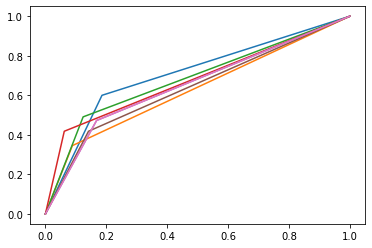

In [13]:
roc_auc=np.zeros((Nmodel,))
acc=np.zeros((Nmodel,))
balacc=np.zeros((Nmodel,))
ppv=np.zeros((Nmodel,))
cm=np.zeros((2,2,Nmodel))

plt.figure()

for j in range(Nmodel):
    fpr, tpr, thresholds = metrics.roc_curve(lab[:,j], est[:,j], pos_label=1)
    plt.plot(fpr,tpr)
    
    roc_auc[j] = metrics.auc(fpr, tpr)
    acc[j] = metrics.accuracy_score(lab[:,j], est[:,j]>0.5)
    balacc[j]= metrics.balanced_accuracy_score(lab[:,j], est[:,j]>0.5)
    ppv[j] = metrics.precision_score(lab[:,j], est[:,j]>0.5)
    cm[:,:,j]=metrics.confusion_matrix(lab[:,j], est[:,j]>0.5)
    


In [14]:
roc_auc

array([0.70707965, 0.62847949, 0.68350764, 0.67811746, 0.65229284,
       0.63829445, 0.65229284])

In [15]:
acc


array([0.74404762, 0.72619048, 0.75      , 0.76785714, 0.71428571,
       0.71428571, 0.71428571])

In [16]:
balacc


array([0.70707965, 0.62847949, 0.68350764, 0.67811746, 0.65229284,
       0.63829445, 0.65229284])